In [8]:
import numpy as np
import hashlib

class CountMinSketch:
    def __init__(self, width, depth, seed=42):
        """Initialize a Count-Min Sketch with specified dimensions."""
        self.width = width
        self.depth = depth
        self.sketch = np.zeros((depth, width), dtype=np.int32)
        self.seeds = [seed + i for i in range(depth)]
    
    def update(self, key, count=1):
        """Update the count for a key in the sketch."""
        key_str = str(key).encode('utf-8')
        for i in range(self.depth):
            bucket = self._hash(key_str, self.seeds[i]) % self.width
            self.sketch[i, bucket] += count
    
    def estimate(self, key):
        """Estimate the count for a key."""
        key_str = str(key).encode('utf-8')
        min_count = float('inf')
        for i in range(self.depth):
            bucket = self._hash(key_str, self.seeds[i]) % self.width
            min_count = min(min_count, self.sketch[i, bucket])
        return min_count
    
    def _hash(self, data, seed):
        """Simple hash function."""
        h = seed
        for byte in data:
            h = (h * 31 + byte) % 2**32
        return h


In [9]:
from collections import defaultdict

class GraphStreamLibrary:
    def __init__(self, width=1000, depth=5, seed=42):
        """Initialize the Graph Stream Library."""
        # Basic sketches for degree estimation
        self.in_degree_sketch = CountMinSketch(width, depth, seed)
        self.out_degree_sketch = CountMinSketch(width, depth, seed+100)
        
        # Sketch for edge frequency
        self.edge_sketch = CountMinSketch(width, depth, seed+200)
        
        # Sketch for node frequency
        self.node_sketch = CountMinSketch(width, depth, seed+300)
        
        # Sketch for degree distribution
        self.degree_distribution_sketch = CountMinSketch(width, depth, seed+400)
        
        # Advanced sketches for subgraph density
        self.subgraph_edges_sketch = CountMinSketch(width, depth, seed+500)
        self.subgraph_nodes_sketch = CountMinSketch(width, depth, seed+600)
        
        # Sketch for community detection
        self.community_sketch = CountMinSketch(width, depth, seed+700)
        
        # Parameters
        self.width = width
        self.depth = depth
        self.seed = seed
        self.edge_count = 0
        
        
    def add_edge(self, source, target, weight=1):
        """Add an edge to the graph stream."""
        # Update degree sketches
        self.out_degree_sketch.update(source, weight)
        self.in_degree_sketch.update(target, weight)
        
        # Update edge frequency
        edge = (source, target)
        self.edge_sketch.update(edge, weight)
        
        # Mark nodes as seen
        self.node_sketch.update(source, 1)
        self.node_sketch.update(target, 1)
        
        # Update degree distribution
        source_degree = self.estimate_out_degree(source)
        target_degree = self.estimate_in_degree(target)
        self.degree_distribution_sketch.update(source_degree, 1)
        self.degree_distribution_sketch.update(target_degree, 1)
        
        # Update subgraph density metrics
        num_subgraphs = 100  # Number of potential subgraphs
        for i in range(num_subgraphs):
            subgraph_id = i
            # Check if edge belongs to this subgraph (simplified approach)
            if (hash(str(source) + str(i)) % 10 == 0) or (hash(str(target) + str(i)) % 10 == 0):
                self.subgraph_edges_sketch.update(subgraph_id, weight)
                self.subgraph_nodes_sketch.update((subgraph_id, source), 1)
                self.subgraph_nodes_sketch.update((subgraph_id, target), 1)
        
        # Update community detection metrics
        community_edge = min(source, target) * self.width + max(source, target)
        self.community_sketch.update(community_edge, weight)
        
        # Increment edge count
        self.edge_count += weight

    def estimate_in_degree(self, node):
        """Estimate in-degree of a node."""
        return self.in_degree_sketch.estimate(node)

    def estimate_out_degree(self, node):
        """Estimate out-degree of a node."""
        return self.out_degree_sketch.estimate(node)

    def estimate_degree(self, node):
        """Estimate total degree of a node."""
        return self.estimate_in_degree(node) + self.estimate_out_degree(node)

    def estimate_degree_distribution(self, max_degree=100):
        """Estimate the degree distribution."""
        distribution = {}
        for degree in range(max_degree + 1):
            count = self.degree_distribution_sketch.estimate(degree)
            if count > 0:
                distribution[degree] = count
        return distribution

    def find_max_density_subgraph(self, num_subgraphs=100):
        """Find the maximum density subgraph."""
        max_density = -1
        max_density_subgraph = -1
        
        for i in range(num_subgraphs):
            subgraph_id = i
            edges = self.subgraph_edges_sketch.estimate(subgraph_id)
            
            # Count unique nodes in the subgraph
            node_count = 0
            for n in range(10000):  # Assume a maximum of 10000 nodes
                if self.subgraph_nodes_sketch.estimate((subgraph_id, n)) > 0:
                    node_count += 1
            
            # Compute density (edges / nodes)
            if node_count > 0:
                density = edges / node_count
                if density > max_density:
                    max_density = density
                    max_density_subgraph = subgraph_id
        
        return (max_density_subgraph, max_density)
    
    
    def detect_communities(self, threshold=5, max_nodes=1000):
        """Detect communities in the graph."""
        # Build an adjacency list from the community sketch
        adjacency = defaultdict(list)
        for i in range(max_nodes):
            for j in range(i+1, max_nodes):
                edge_id = i * self.width + j
                edge_count = self.community_sketch.estimate(edge_id)
                if edge_count >= threshold:
                    adjacency[i].append(j)
                    adjacency[j].append(i)
        
        # Simple community detection using connected components
        communities = {}
        visited = set()
        
        def dfs(node, community_id):
            visited.add(node)
            communities[node] = community_id
            for neighbor in adjacency[node]:
                if neighbor not in visited:
                    dfs(neighbor, community_id)
        
        community_id = 0
        for node in range(max_nodes):
            if node in adjacency and node not in visited:
                dfs(node, community_id)
                community_id += 1
        
        return communities

    def detect_anomalies(self, threshold=3):
        """Detect anomalies in the graph stream."""
        # Get the distribution of edge frequencies
        edge_freqs = []
        for i in range(self.width):
            for j in range(self.depth):
                edge_freqs.append(self.edge_sketch.sketch[j, i])
        
        # Calculate mean and standard deviation
        mean = np.mean(edge_freqs)
        std = np.std(edge_freqs)
        
        # Find anomalies (edges with frequency above threshold)
        anomalies = []
        for i in range(1000):  # Assume a maximum of 1000 nodes
            for j in range(1000):
                freq = self.estimate_edge_frequency(i, j)
                if freq > 0:
                    z_score = (freq - mean) / std if std > 0 else 0
                    if z_score > threshold:
                        anomalies.append((i, j, z_score))
        
        return sorted(anomalies, key=lambda x: x[2], reverse=True)


    def visualize_degree_distribution(self, max_degree=100, update_interval=1000):
        """Visualize the degree distribution in real-time."""
        import matplotlib.pyplot as plt
        import matplotlib.animation as animation
        from matplotlib.ticker import MaxNLocator
        
        # Create figure and axes
        fig, ax = plt.subplots(figsize=(10, 6))
        
        def animate(i):
            # Get current degree distribution
            distribution = self.estimate_degree_distribution(max_degree)
            
            # Convert to lists for plotting
            degrees = list(distribution.keys())
            counts = list(distribution.values())
            
            # Clear previous plot
            ax.clear()
            
            # Create new bar chart
            ax.bar(degrees, counts, alpha=0.7)
            
            # Set labels and title
            ax.set_xlabel('Node Degree')
            ax.set_ylabel('Count')
            ax.set_title('Estimated Degree Distribution')
            
            # Set x-axis to show integer ticks
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        # Create animation
        ani = animation.FuncAnimation(fig, animate, interval=update_interval)
        
        # Show plot
        plt.tight_layout()
        plt.show()

    


In [10]:
def demo_graph_stream_library():
    """Demonstrate the use of the Graph Stream Library."""
    # Initialize the library
    gsl = GraphStreamLibrary(width=1000, depth=5)
    
    # Add some edges to the stream
    edges = [
        (1, 2), (2, 3), (3, 4), (4, 1),  # Community 1
        (5, 6), (6, 7), (7, 8), (8, 5),  # Community 2
        (1, 5)  # Bridge edge
    ]
    
    for source, target in edges:
        gsl.add_edge(source, target)
    
    # Estimate degrees
    print("Estimated degrees:")
    for node in range(1, 9):
        print(f"Node {node}: in={gsl.estimate_in_degree(node)}, out={gsl.estimate_out_degree(node)}")
    
    # Estimate degree distribution
    print("\nEstimated degree distribution:")
    distribution = gsl.estimate_degree_distribution(max_degree=10)
    for degree, count in sorted(distribution.items()):
        print(f"Degree {degree}: {count} nodes")
    
    # Find maximum density subgraph
    subgraph_id, density = gsl.find_max_density_subgraph()
    print(f"\nMaximum density subgraph: {subgraph_id} with density {density:.2f}")
    
    # Detect communities
    communities = gsl.detect_communities(threshold=1)
    print("\nDetected communities:")
    community_groups = defaultdict(list)
    for node, community in communities.items():
        if node < 10:  # Only show nodes 1-9 for clarity
            community_groups[community].append(node)
    
    for community, nodes in community_groups.items():
        print(f"Community {community}: {nodes}")


demo_graph_stream_library()

Estimated degrees:
Node 1: in=1, out=2
Node 2: in=1, out=1
Node 3: in=1, out=1
Node 4: in=1, out=1
Node 5: in=2, out=1
Node 6: in=1, out=1
Node 7: in=1, out=1
Node 8: in=1, out=1

Estimated degree distribution:
Degree 1: 16 nodes
Degree 2: 2 nodes

Maximum density subgraph: 28 with density 0.83

Detected communities:
Community 0: [1, 2, 3, 4, 6, 5, 8, 7]
Community 1: [9]


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Define CountMinSketch (simplistic implementation for demonstration)
class CountMinSketch:
    def __init__(self, width, depth, seed=0):
        np.random.seed(seed)
        self.width = width
        self.depth = depth
        self.sketch = np.zeros((depth, width), dtype=int)
        # simple hash functions: random a,b for ax+b mod width
        self.hash_params = [(np.random.randint(1, width), np.random.randint(0, width)) for _ in range(depth)]

    def _hash(self, x, i):
        a, b = self.hash_params[i]
        return (a * hash(x) + b) % self.width

    def update(self, key, count=1):
        for i in range(self.depth):
            idx = self._hash(key, i)
            self.sketch[i, idx] += count

    def estimate(self, key):
        return min(self.sketch[i, self._hash(key, i)] for i in range(self.depth))

# Paste GraphStreamLibrary
class GraphStreamLibrary:
    def __init__(self, width=1000, depth=5, seed=42):
        self.in_degree_sketch = CountMinSketch(width, depth, seed)
        self.out_degree_sketch = CountMinSketch(width, depth, seed+100)
        self.edge_sketch = CountMinSketch(width, depth, seed+200)
        self.node_sketch = CountMinSketch(width, depth, seed+300)
        self.degree_distribution_sketch = CountMinSketch(width, depth, seed+400)
        self.subgraph_edges_sketch = CountMinSketch(width, depth, seed+500)
        self.subgraph_nodes_sketch = CountMinSketch(width, depth, seed+600)
        self.community_sketch = CountMinSketch(width, depth, seed+700)
        self.width = width
        self.depth = depth
        self.seed = seed
        self.edge_count = 0

    def add_edge(self, source, target, weight=1):
        self.out_degree_sketch.update(source, weight)
        self.in_degree_sketch.update(target, weight)
        edge = (source, target)
        self.edge_sketch.update(edge, weight)
        self.node_sketch.update(source, 1); self.node_sketch.update(target, 1)
        src_deg = self.estimate_out_degree(source); tgt_deg = self.estimate_in_degree(target)
        self.degree_distribution_sketch.update(src_deg, 1); self.degree_distribution_sketch.update(tgt_deg, 1)
        # simplified subgraph update
        for i in range(20):
            if hash((source,i)) % 10 == 0 or hash((target,i)) % 10 == 0:
                self.subgraph_edges_sketch.update(i, weight)
                self.subgraph_nodes_sketch.update((i,source), 1)
                self.subgraph_nodes_sketch.update((i,target), 1)
        comm_edge = min(source, target) * self.width + max(source, target)
        self.community_sketch.update(comm_edge, weight)
        self.edge_count += weight

    def estimate_in_degree(self, node): return self.in_degree_sketch.estimate(node)
    def estimate_out_degree(self, node): return self.out_degree_sketch.estimate(node)
    def estimate_degree(self, node): return self.estimate_in_degree(node) + self.estimate_out_degree(node)

    def estimate_degree_distribution(self, max_degree=100):
        dist = {}
        for d in range(max_degree+1):
            c = self.degree_distribution_sketch.estimate(d)
            if c > 0: dist[d] = c
        return dist

    def find_max_density_subgraph(self, num_subgraphs=20):
        best, best_den = -1, -1
        for i in range(num_subgraphs):
            edges = self.subgraph_edges_sketch.estimate(i)
            nodes = sum(1 for n in range(10000) if self.subgraph_nodes_sketch.estimate((i,n)) > 0)
            if nodes>0:
                den = edges/nodes
                if den>best_den: best_den, best = den, i
        return best, best_den

    def detect_communities(self, threshold=5, max_nodes=1000):
        adj = defaultdict(list)
        for i in range(max_nodes):
            for j in range(i+1, max_nodes):
                eid = i*self.width+j
                if self.community_sketch.estimate(eid)>=threshold:
                    adj[i].append(j); adj[j].append(i)
        visited = set(); comm = {}
        def dfs(u,cid):
            visited.add(u); comm[u]=cid
            for v in adj[u]:
                if v not in visited: dfs(v,cid)
        cid=0
        for n in range(max_nodes):
            if n in adj and n not in visited:
                dfs(n,cid); cid+=1
        return comm

    def detect_anomalies(self, threshold=3):
        freqs = self.edge_sketch.sketch.flatten()
        mean, std = freqs.mean(), freqs.std()
        anoms = []
        for i in range(100):
            for j in range(100):
                f = self.edge_sketch.estimate((i,j))
                if f>0:
                    z = (f-mean)/std if std>0 else 0
                    if z>threshold: anoms.append((i,j,z))
        return sorted(anoms, key=lambda x: -x[2])
 

Top 10 Nodes by Estimated Degree


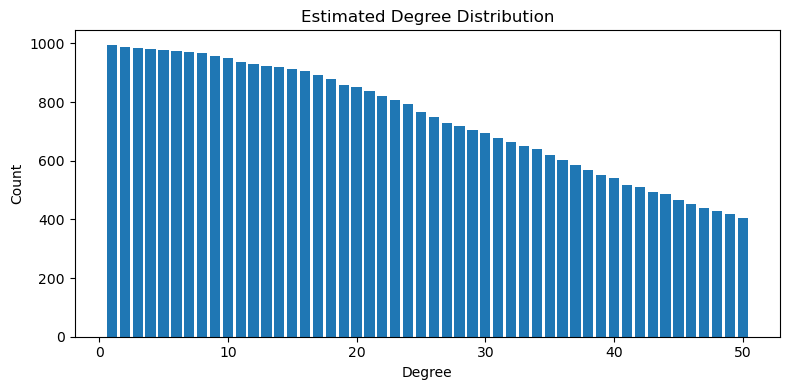

Densest subgraph: ID=2 with density=0.608
Community vs Department Composition


Top Anomalous Edges


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Load datasets
labels_df = pd.read_csv('./dataset/email-Eu-core-department-labels.txt', sep=' ', header=None, names=['node','dept'])
edges_df = pd.read_csv('./dataset/email-Eu-core.txt', sep=' ', header=None, names=['source','target'])

labels = labels_df.set_index('node')['dept'].to_dict()
nodes = set(labels.keys()) | set(edges_df['source']) | set(edges_df['target'])

# Instantiate and feed edges
gsl = GraphStreamLibrary(width=500, depth=5, seed=42)
for _, row in edges_df.iterrows():
    gsl.add_edge(int(row.source), int(row.target))

# Top 10 nodes by estimated total degree
top_nodes = sorted(nodes, key=lambda n: gsl.estimate_degree(n), reverse=True)[:10]
degree_data = [(n, gsl.estimate_in_degree(n), gsl.estimate_out_degree(n), gsl.estimate_degree(n), labels.get(n, None)) for n in top_nodes]
df_top = pd.DataFrame(degree_data, columns=['node','in_deg','out_deg','total_deg','dept'])

# Display top nodes
import ace_tools_open as tools
tools.display_dataframe_to_user("Top 10 Nodes by Estimated Degree", df_top)

# Plot degree distribution
dist = gsl.estimate_degree_distribution(max_degree=50)
plt.figure(figsize=(8,4))
plt.bar(list(dist.keys()), list(dist.values()))
plt.xlabel('Degree'); plt.ylabel('Count')
plt.title('Estimated Degree Distribution')
plt.tight_layout()
plt.show()

# Densest subgraph
sub_id, density = gsl.find_max_density_subgraph(num_subgraphs=20)
print(f"Densest subgraph: ID={sub_id} with density={density:.3f}")

# Community composition by department
comm = gsl.detect_communities(threshold=10, max_nodes=max(nodes)+1)
comm_df = pd.DataFrame(list(comm.items()), columns=['node','comm_id'])
comm_df['dept'] = comm_df['node'].map(labels)
comp = comm_df.groupby(['comm_id','dept']).size().reset_index(name='count')
tools.display_dataframe_to_user("Community vs Department Composition", comp)

# Top anomalies
anoms = gsl.detect_anomalies(threshold=4)[:10]
df_anom = pd.DataFrame(anoms, columns=['source','target','z_score'])
tools.display_dataframe_to_user("Top Anomalous Edges", df_anom)
